## Mixtures of experts
### A. EM-algorithm

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def softmax_gating(gamma, X):
    
    """Softmax gating"""
    
    temp  = np.exp(np.matmul(X, gamma.T))
    sum_temp = np.repeat( np.sum(temp,1).reshape(-1,1), repeats=n_components,axis=1)
    softmax = np.divide(temp, sum_temp)
    
    return softmax


def conditional_gaussian(X, y, beta, sigma):
    
    """Conditional probability of the target"""
    
    y_hat = np.matmul(X, beta.T)
    y_re = np.repeat(y, repeats=n_components, axis=1 )
    output = np.exp((-(y_re-y_hat)**2)/(2*sigma**2)) / (np.sqrt(2*np.pi)*sigma)

    return output

def find_w (X, y, gamma, beta, sigma ):
    
    """Computation of optimal w"""
    
    y_re = np.repeat(y, repeats=n_components, axis=1 )
    temp1 = np.matmul(X, gamma.T)
    temp2 = np.matmul(X, beta.T)
    temp2 = (-(y_re-temp2)**2)/(2*sigma**2)
    temp2 = np.exp(temp1 + temp2)
    sum_temp = np.repeat( np.sum(temp2,1).reshape(-1,1), repeats=n_components,axis=1)
    
    output = np.divide(temp2, sum_temp)
    
    return output

def find_sigma (X, y, gamma, beta):
    
    """Computation of optimal sigma"""

    y_re = np.repeat(y, repeats=n_components, axis=1 )
    temp = np.matmul(X, beta.T)
    output = np.sqrt(np.mean(np.multiply(w, (y_re-temp))**2))

    return output

def find_beta (X, y, w):
    
    """Computation of optimal beta"""
    
    beta = np.zeros((n_components, n_features))
    
    for i in range(n_components):
        beta[i,:] = (np.linalg.inv(X.T@np.diag(w[:,i])@X+\
            lambd*np.eye(n_features))@(X.T@np.diag(w[:,i])@y)).T
        
    return beta

def grad_gamma(X, w, gamma):
    
    """Gradient of loss w.r.t gamma"""
    
    S = softmax_gating(gamma, X)
    output = X.T@(w-S)
    return output

def hessian_gamma(X, w, gamma):
    
    """Hessian of the loss w.r.t. gamma"""
    
    S = softmax_gating(gamma, X)
    hessian = np.zeros((n_components,n_features,n_features))
    
    for i in range(n_components):
        S_ = np.diag(np.multiply(S[:,i], 1-S[:,i]))
        hessian[i,:,:] = -X.T@S_@X + lambd*np.eye(n_features)
        
    return hessian

def mixture_prediction(X, gamma, beta, sigma, w):
    
    """Prediction of the mixture of experts"""
    
    mean = np.matmul(X, beta.T)
    gate = softmax_gating(gamma, X)
    output = np.sum(np.multiply(mean, gate), axis=1)
    
    return output

def log_loss(X, y, gamma, beta, sigma, w):
    
    """Logarithmic loss"""
    
    delta=0.000001
    gate = softmax_gating(gamma, X)
    cond = conditional_gaussian(X, y, beta, sigma)
    output = np.sum(np.multiply(w, np.log(gate+delta)+np.log(cond+delta)))
    
    return -output


def expectation_maximixation(X, y, gamma, beta, sigma, w, n_iterations):
    
    for j in range(n_iterations):
        
        #update beta
        beta = find_beta(X, y,w)

        #update sigma
        sigma = find_sigma (X, y, gamma, beta)

        #update gamma
        grad = grad_gamma(X, w, gamma)
        h = hessian_gamma(X, w, gamma)
        prev_grad = 0
        while (np.sum((grad-prev_grad)**2)>0.01):

            for i in range(n_components):
                gamma[i,:] = gamma[i,:] - \
                    0.01*(np.linalg.inv(h[i,:,:])@grad[:,i]).T
            prev_grad = grad
            grad = grad_gamma(X, w, gamma)
            h = hessian_gamma(X, w, gamma)

        #update w
        w=find_w (X, y, gamma, beta, sigma)

        #calculate loss
        l = log_loss(X, y, gamma, beta, sigma, w)
        
    return gamma, beta, sigma, w

### B. Fitting model and making predictions 

In [3]:
#reading the data
file = open("heights1.dat", 'r') #first column is age, second column is height
text = file.read()
lines = text.split("\n")
lines_data = [l.split(" ") for l in lines]
lines_data = np.array(lines_data[1:-1]).astype(float)
X = lines_data[:,0].reshape(-1,1)
y = lines_data[:,1].reshape(-1,1)
n_samples = X.shape[0]

#normalizing data
max_X = max(X)
max_y = max(y)

X = X/max_X
y = y/max_y

X = np.hstack((np.ones((n_samples,1)), X))

#initialize variables and parameters
n_components = 2
n_features = 2
gamma = np.random.random((n_components, n_features))*0.001
beta= np.random.random((n_components, n_features))*0.001
sigma = 0.1
lambd = 0.00001
n_iterations = 100

w=find_w (X, y, gamma, beta, sigma)

l = log_loss(X, y, gamma, beta, sigma, w)
print("Initial loss:", l)

Initial loss: 3111.647978349524


In [4]:
print("Training model...")
gamma, beta, sigma, w = expectation_maximixation(X, y, gamma, \
                                        beta, sigma, w, n_iterations)

Training model...


Text(0,0.5,'Height (cm)')

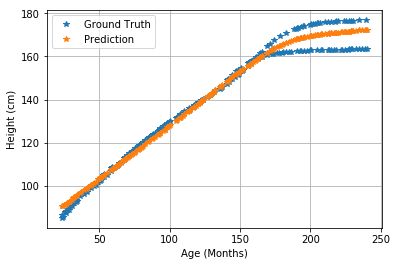

In [5]:
y_hat= mixture_prediction(X, gamma, beta, sigma, w)
y_hat=y_hat*max_y

y_original=y*max_y

plt.plot(X[:,1]*max_X, y_original,"*")
plt.plot(X[:,1]*max_X, y_hat, "*")
plt.grid()
plt.legend(("Ground Truth", "Prediction"))
plt.xlabel("Age (Months)")
plt.ylabel("Height (cm)")

In [6]:
print("Gamma:", gamma)
print("Beta:", beta)
print("Sigma:", sigma)

Gamma: [[ 5.13131502 -6.60316152]
 [-5.13048113  6.60400444]]
Beta: [[0.44419972 0.66525488]
 [0.79762138 0.17073626]]
Sigma: 0.05818507404532477


Text(0.5,1,'Gating function')

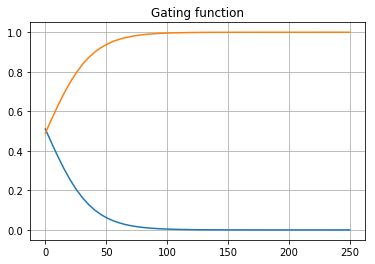

In [7]:
X_test = np.linspace(0,250).reshape(-1,1)
X_test = np.hstack((np.ones((X_test.shape[0],1)), X_test))
y_test = softmax_gating(gamma,X_test/max_X)
plt.plot(X_test[:, 1], y_test)
plt.grid()
plt.title("Gating function")

### C.



In [8]:
#reading the data
file = open("heights2-2.dat", 'r') #first column is age, second column is height
text = file.read()
lines = text.split("\n")
lines_data = [l.split(" ") for l in lines]
lines_data = np.array(lines_data[1:-1]).astype(float)
X = lines_data[:,0].reshape(-1,1)
y = lines_data[:,1].reshape(-1,1)
n_samples = X.shape[0]

#normalizing data
max_X = max(X)
max_y = max(y)

X = X/max_X
y = y/max_y

X = np.hstack((np.ones((n_samples,1)), X))

#initialize variables and parameters
n_components = 3
n_features = 2
gamma = np.random.random((n_components, n_features))*0.001
beta= np.random.random((n_components, n_features))*0.001
#w = np.random.random((n_samples, n_components))
sigma = 0.1
lambd = 0.00001
n_iterations = 100

w=find_w (X, y, gamma, beta, sigma)

l = log_loss(X, y, gamma, beta, sigma, w)
print("Initial loss:", l)

Initial loss: 6420.150746287205


In [9]:
print("Training model...")
gamma, beta, sigma, w = expectation_maximixation(X, y, gamma, beta, sigma, w, n_iterations)

Training model...


Text(0,0.5,'Height (cm)')

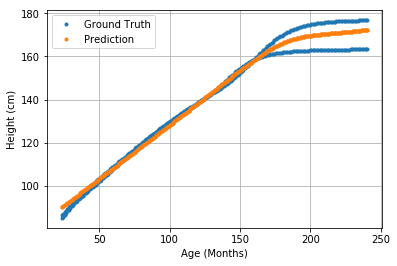

In [12]:
y_hat= mixture_prediction(X, gamma, beta, sigma, w)
y_hat=y_hat*max_y

y_original=y*max_y

plt.plot(X[:,1]*max_X, y_original,".")
plt.plot(X[:,1]*max_X, y_hat, ".")
plt.grid()
plt.legend(("Ground Truth", "Prediction"))
plt.xlabel("Age (Months)")
plt.ylabel("Height (cm)")

In [49]:
print("Gamma:", gamma)
print("Beta:", beta)
print("Sigma:", sigma)

Gamma: [[  2.67280952  -4.43374797]
 [  0.31008364  -0.59673557]
 [-16.19387144  21.089807  ]]
Beta: [[0.43645282 0.6910093 ]
 [0.4518045  0.65692683]
 [0.82566161 0.143176  ]]
Sigma: 0.03402452936693865


Text(0.5,1,'Gating function')

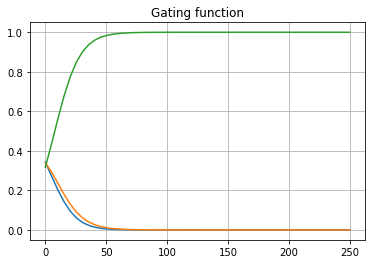

In [50]:
X_test = np.linspace(0,250).reshape(-1,1)
X_test = np.hstack((np.ones((X_test.shape[0],1)), X_test))
y_test = softmax_gating(gamma,X_test/max_X)
plt.plot(X_test[:, 1], y_test)
plt.grid()
plt.title("Gating function")

Prediction for a person of 21 years old: 

In [13]:
y_pred = mixture_prediction(np.array([[1,(21*12)/max_X[0]]]), gamma, beta, sigma, w)
print("Prediction for person with 21 years old", (y_pred*max_y)[0])

Prediction for person with 21 years old 173.34129042368576
